In [33]:
import sys
# !{sys.executable} -m spacy download en
import re, numpy as np, pandas as pd
from pprint import pprint

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt
from nltk.stem.wordnet import WordNetLemmatizer as lemmatizer
import matplotlib.colors as mcolors
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'hotel', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])

%matplotlib inline
warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

In [ ]:
period_name = 'postcovid'

In [10]:
df = pd.read_csv(f'{period_name}.csv')
df.head()

,Unnamed: 0,date,review_text,rating
0,0,2023-05-01,Five stars hotel from beginig to end. Permisse...,5
1,1,2023-02-01,Paradise does indeed exist!\nI absolutely LOVE...,4
2,2,2022-11-01,Had an absolutely fantastic time at this prope...,5
3,3,2022-10-01,Hotel is in a beautiful setting and the servic...,4
4,4,2022-10-01,So worthy of their Conde Nast award - and beyo...,5


In [11]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

# Convert to list
data = df['review_text'].values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1])

[['five', 'stars', 'hotel', 'from', 'beginig', 'to', 'end', 'permisses', 'staff', 'room', 'comon', 'areas', 'made', 'our', 'stay', 'amazing', 'es', 'vedra', 'overlooking', 'the', 'hotel', 'made', 'an', 'unforgetable', 'experience', 'thank', 'you', 'hyatt', 'and', 'magical', 'ibiza', 'we', 'will', 'be', 'back']]


In [13]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# !python3 -m spacy download en  # run in terminal once
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
    #nlp = spacy.load('en', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)  # processed Text Data!

In [15]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=3, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

pprint(lda_model.print_topics())

[(0,
  '0.039*"pool" + 0.020*"room" + 0.019*"restaurant" + 0.019*"food" + '
  '0.016*"bar" + 0.015*"area" + 0.014*"child" + 0.014*"bed" + 0.013*"kid" + '
  '0.013*"lovely"'),
 (1,
  '0.040*"staff" + 0.033*"stay" + 0.027*"great" + 0.023*"friendly" + '
  '0.019*"amazing" + 0.018*"service" + 0.018*"room" + 0.015*"food" + '
  '0.014*"recommend" + 0.014*"back"'),
 (2,
  '0.028*"room" + 0.012*"service" + 0.012*"stay" + 0.011*"day" + 0.011*"time" '
  '+ 0.010*"night" + 0.009*"star" + 0.009*"staff" + 0.009*"ask" + '
  '0.007*"guest"')]


In [16]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

C:\Users\SamOz.py\AppData\Local\Temp\ipykernel_9160\1516627226.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1,0.7933,"staff, stay, great, friendly, amazing, service...","[star, beginig, end, permisse, staff, room, ar..."
1,1,1,0.6936,"staff, stay, great, friendly, amazing, service...","[indeed, exist, absolutely, love, reason, view..."
2,2,1,0.7715,"staff, stay, great, friendly, amazing, service...","[absolutely, fantastic, time, property, accomm..."
3,3,1,0.4279,"staff, stay, great, friendly, amazing, service...","[beautiful, setting, service, faultless, espec..."
4,4,1,0.6135,"staff, stay, great, friendly, amazing, service...","[worthy, third, stay, wonderful, time, set, st..."
5,5,1,0.5497,"staff, stay, great, friendly, amazing, service...","[wonderful, totally, faultless, room, spacious..."
6,6,1,0.4793,"staff, stay, great, friendly, amazing, service...","[pine, son, husband, love, especially, treatme..."
7,7,1,0.8725,"staff, stay, great, friendly, amazing, service...","[perfect, place, set, service, family, wedding..."
8,8,1,0.5901,"staff, stay, great, friendly, amazing, service...","[beautiful, incredible, facility, pool, restau..."
9,9,1,0.5647,"staff, stay, great, friendly, amazing, service...","[pine, beautifully, locate, great, service, mi..."


In [71]:
df_dominant_topic.sample(5)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
12074,12074,0,0.5335,"pool, room, restaurant, food, bar, area, child, bed, kid, lovely","[stay, ever, first, time, away, child, eld, covid, baby, love, expect, staff, fantastic, staff, ..."
18802,18802,2,0.4463,"room, service, stay, day, time, night, star, staff, ask, guest","[fantastic, time, sunbed, struggle, pool, pay, much, money, time, monitor, rule, well, choice, w..."
17345,17345,1,0.4942,"staff, stay, great, friendly, amazing, service, room, food, recommend, back","[return, home, wonderful, time, believe, negative, review, guest, tenerife, ever, visit, ok, loc..."
15509,15509,0,0.4891,"pool, room, restaurant, food, bar, area, child, bed, kid, lovely","[fantastic, place, everywhere, spotlessly, clean, breakfast, amazing, much, selection, difficult..."
23109,23109,1,0.5048,"staff, stay, great, friendly, amazing, service, room, food, recommend, back","[festival, madcool, day, event, pride, thousand, people, yet, street, free, little, pleasure, ro..."


In [17]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0,0.9824,"pool, room, restaurant, food, bar, area, child, bed, kid, lovely","[excellent, clean, excellent, facility, family, young, child, age, food, night, restaurant, choo..."
1,1,0.9855,"staff, stay, great, friendly, amazing, service, room, food, recommend, back","[beautiful, seville, choose, stay, seville, day, spend, first, day, jewish, quarter, sight, pers..."
2,2,0.9878,"room, service, stay, day, time, night, star, staff, ask, guest","[picture, look, well, actual, room, small, wear, else, main, issue, bonvoy, point, day, third, d..."


IndexError: list index out of range

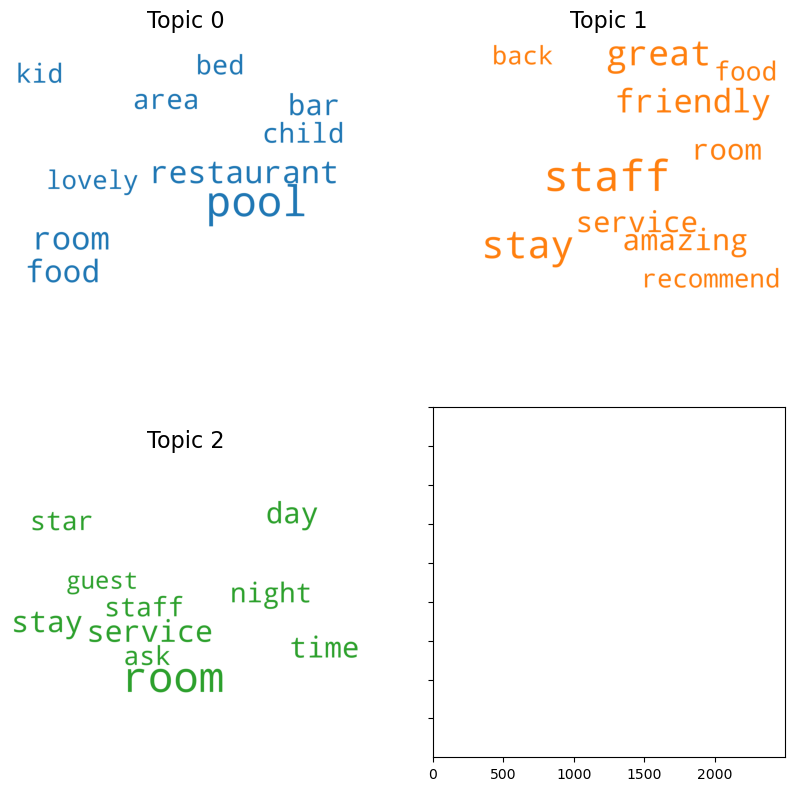

In [18]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

C:\Users\SamOz.py\AppData\Local\Temp\ipykernel_9160\3603844383.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')


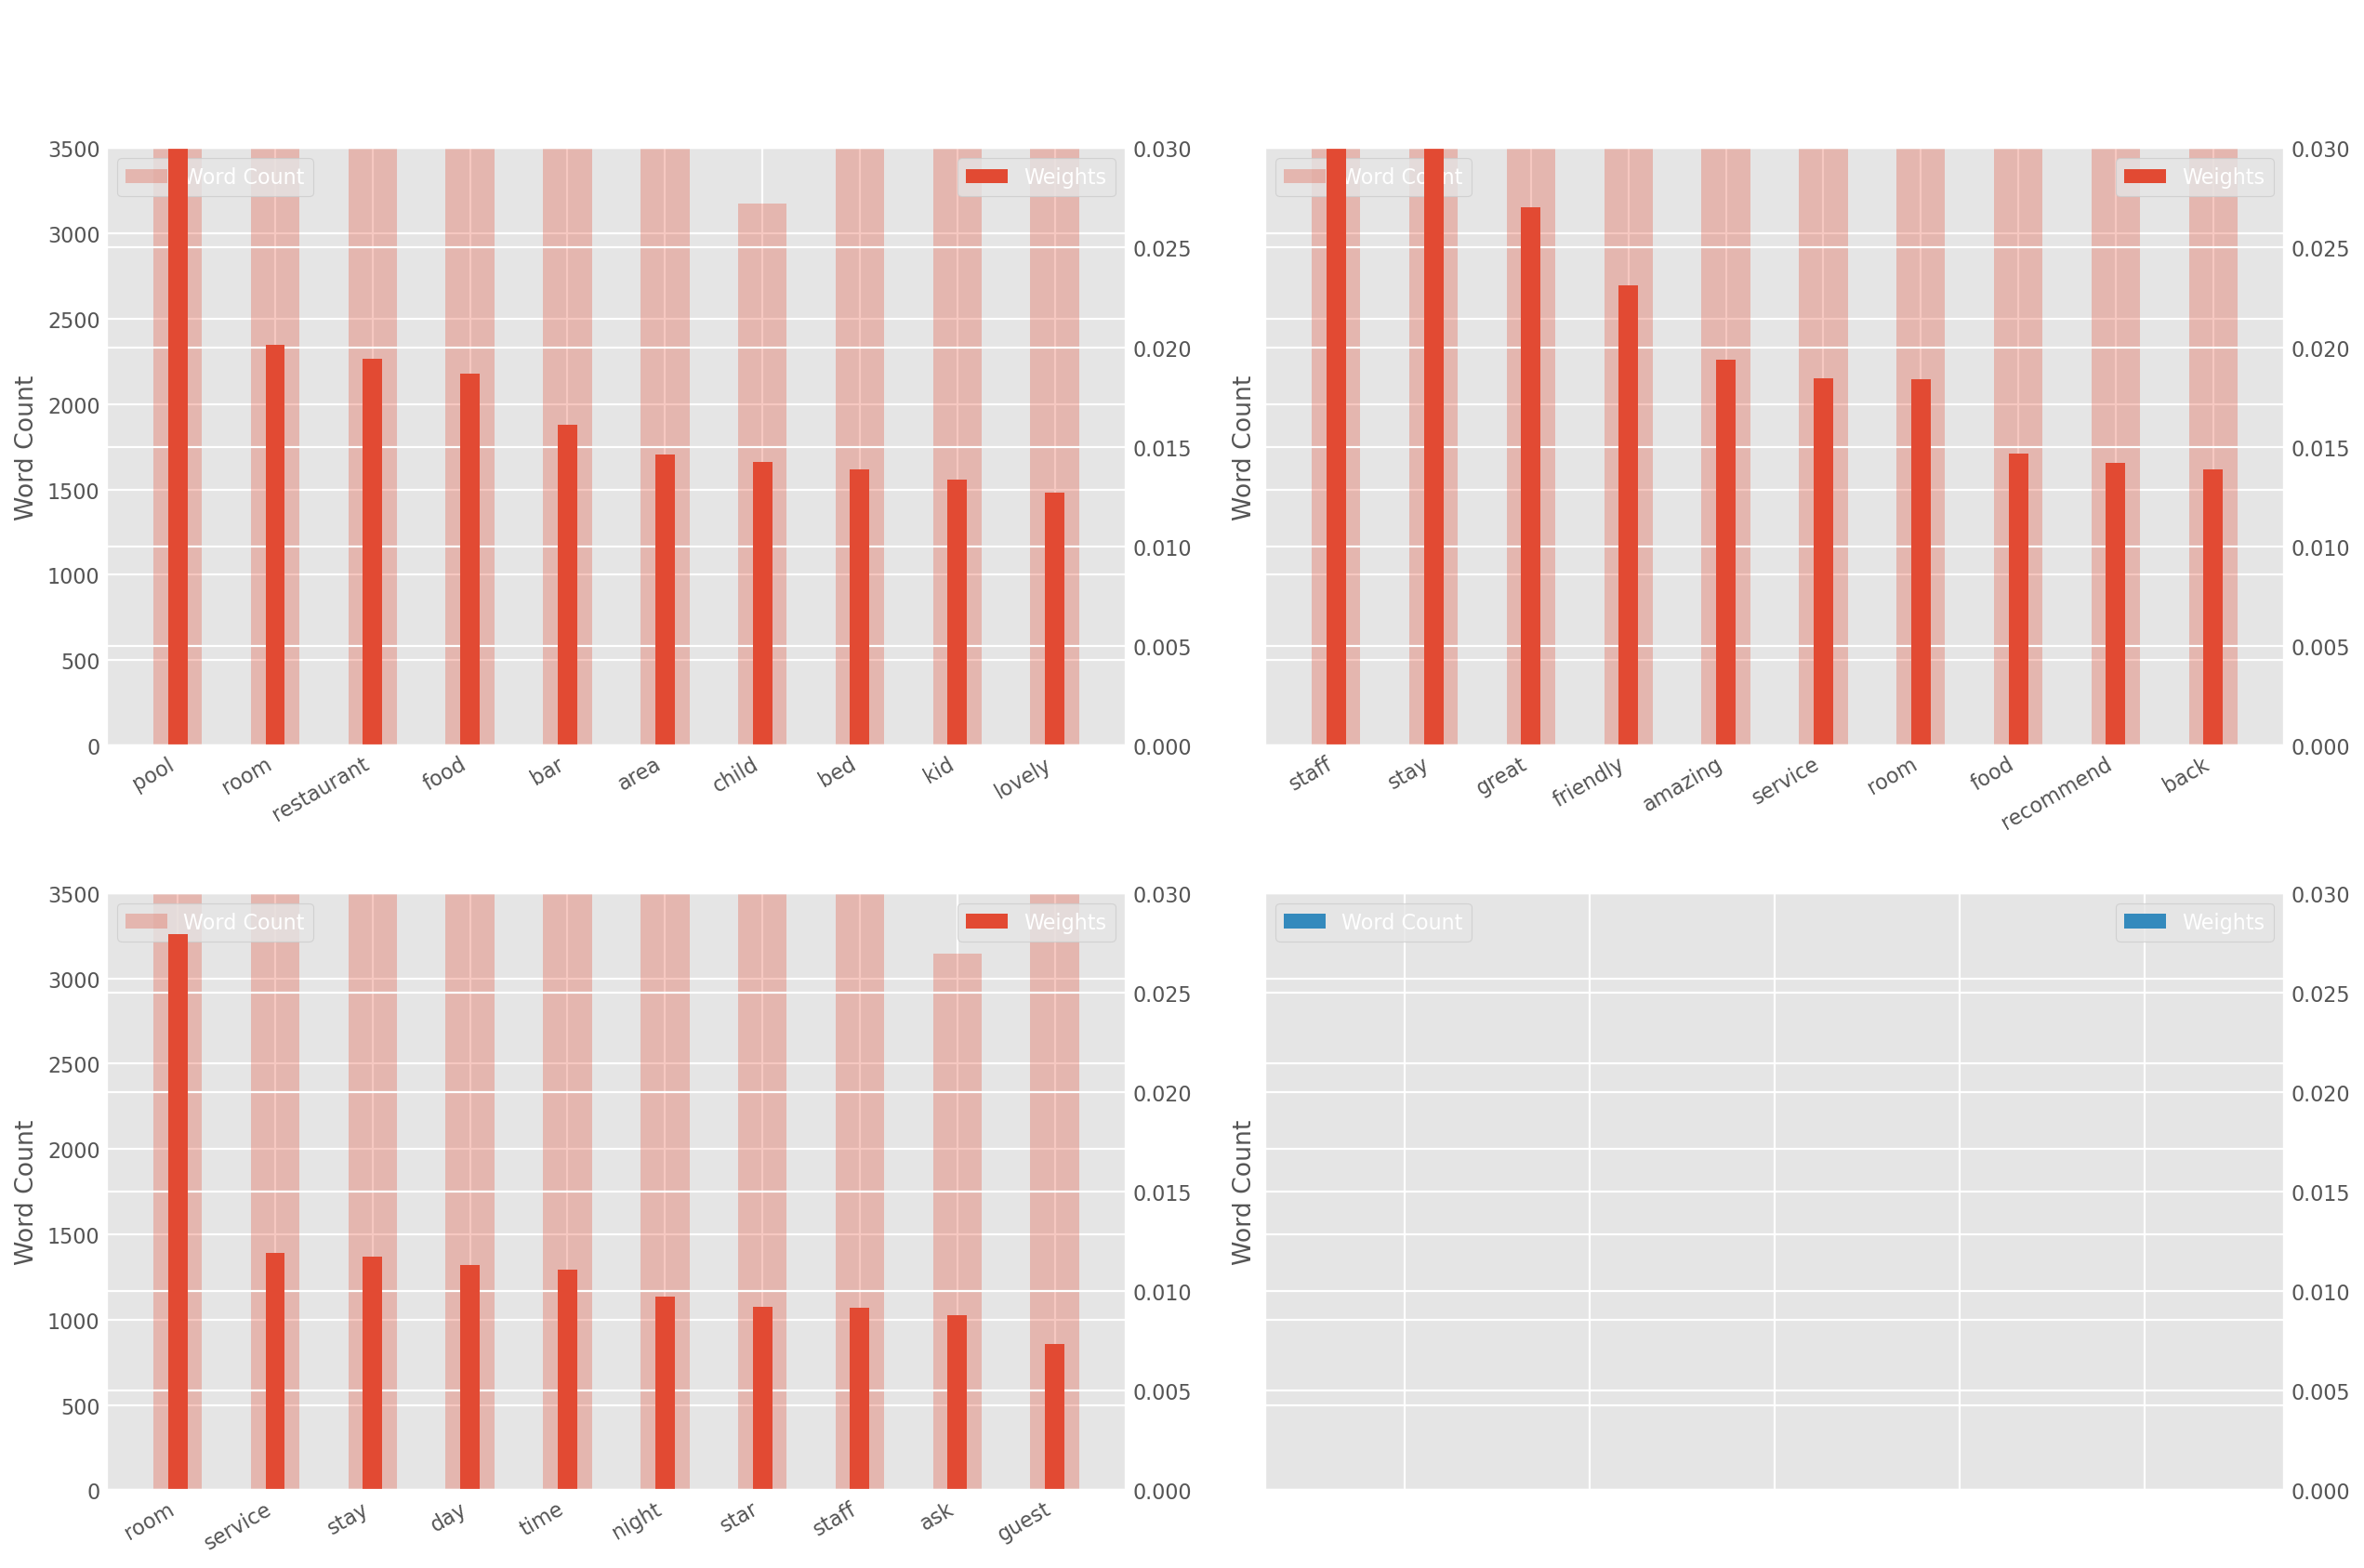

In [50]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

plt.style.use('ggplot')

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], width=0.2, label='Weights')
    ax.set_ylabel('Word Count')
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

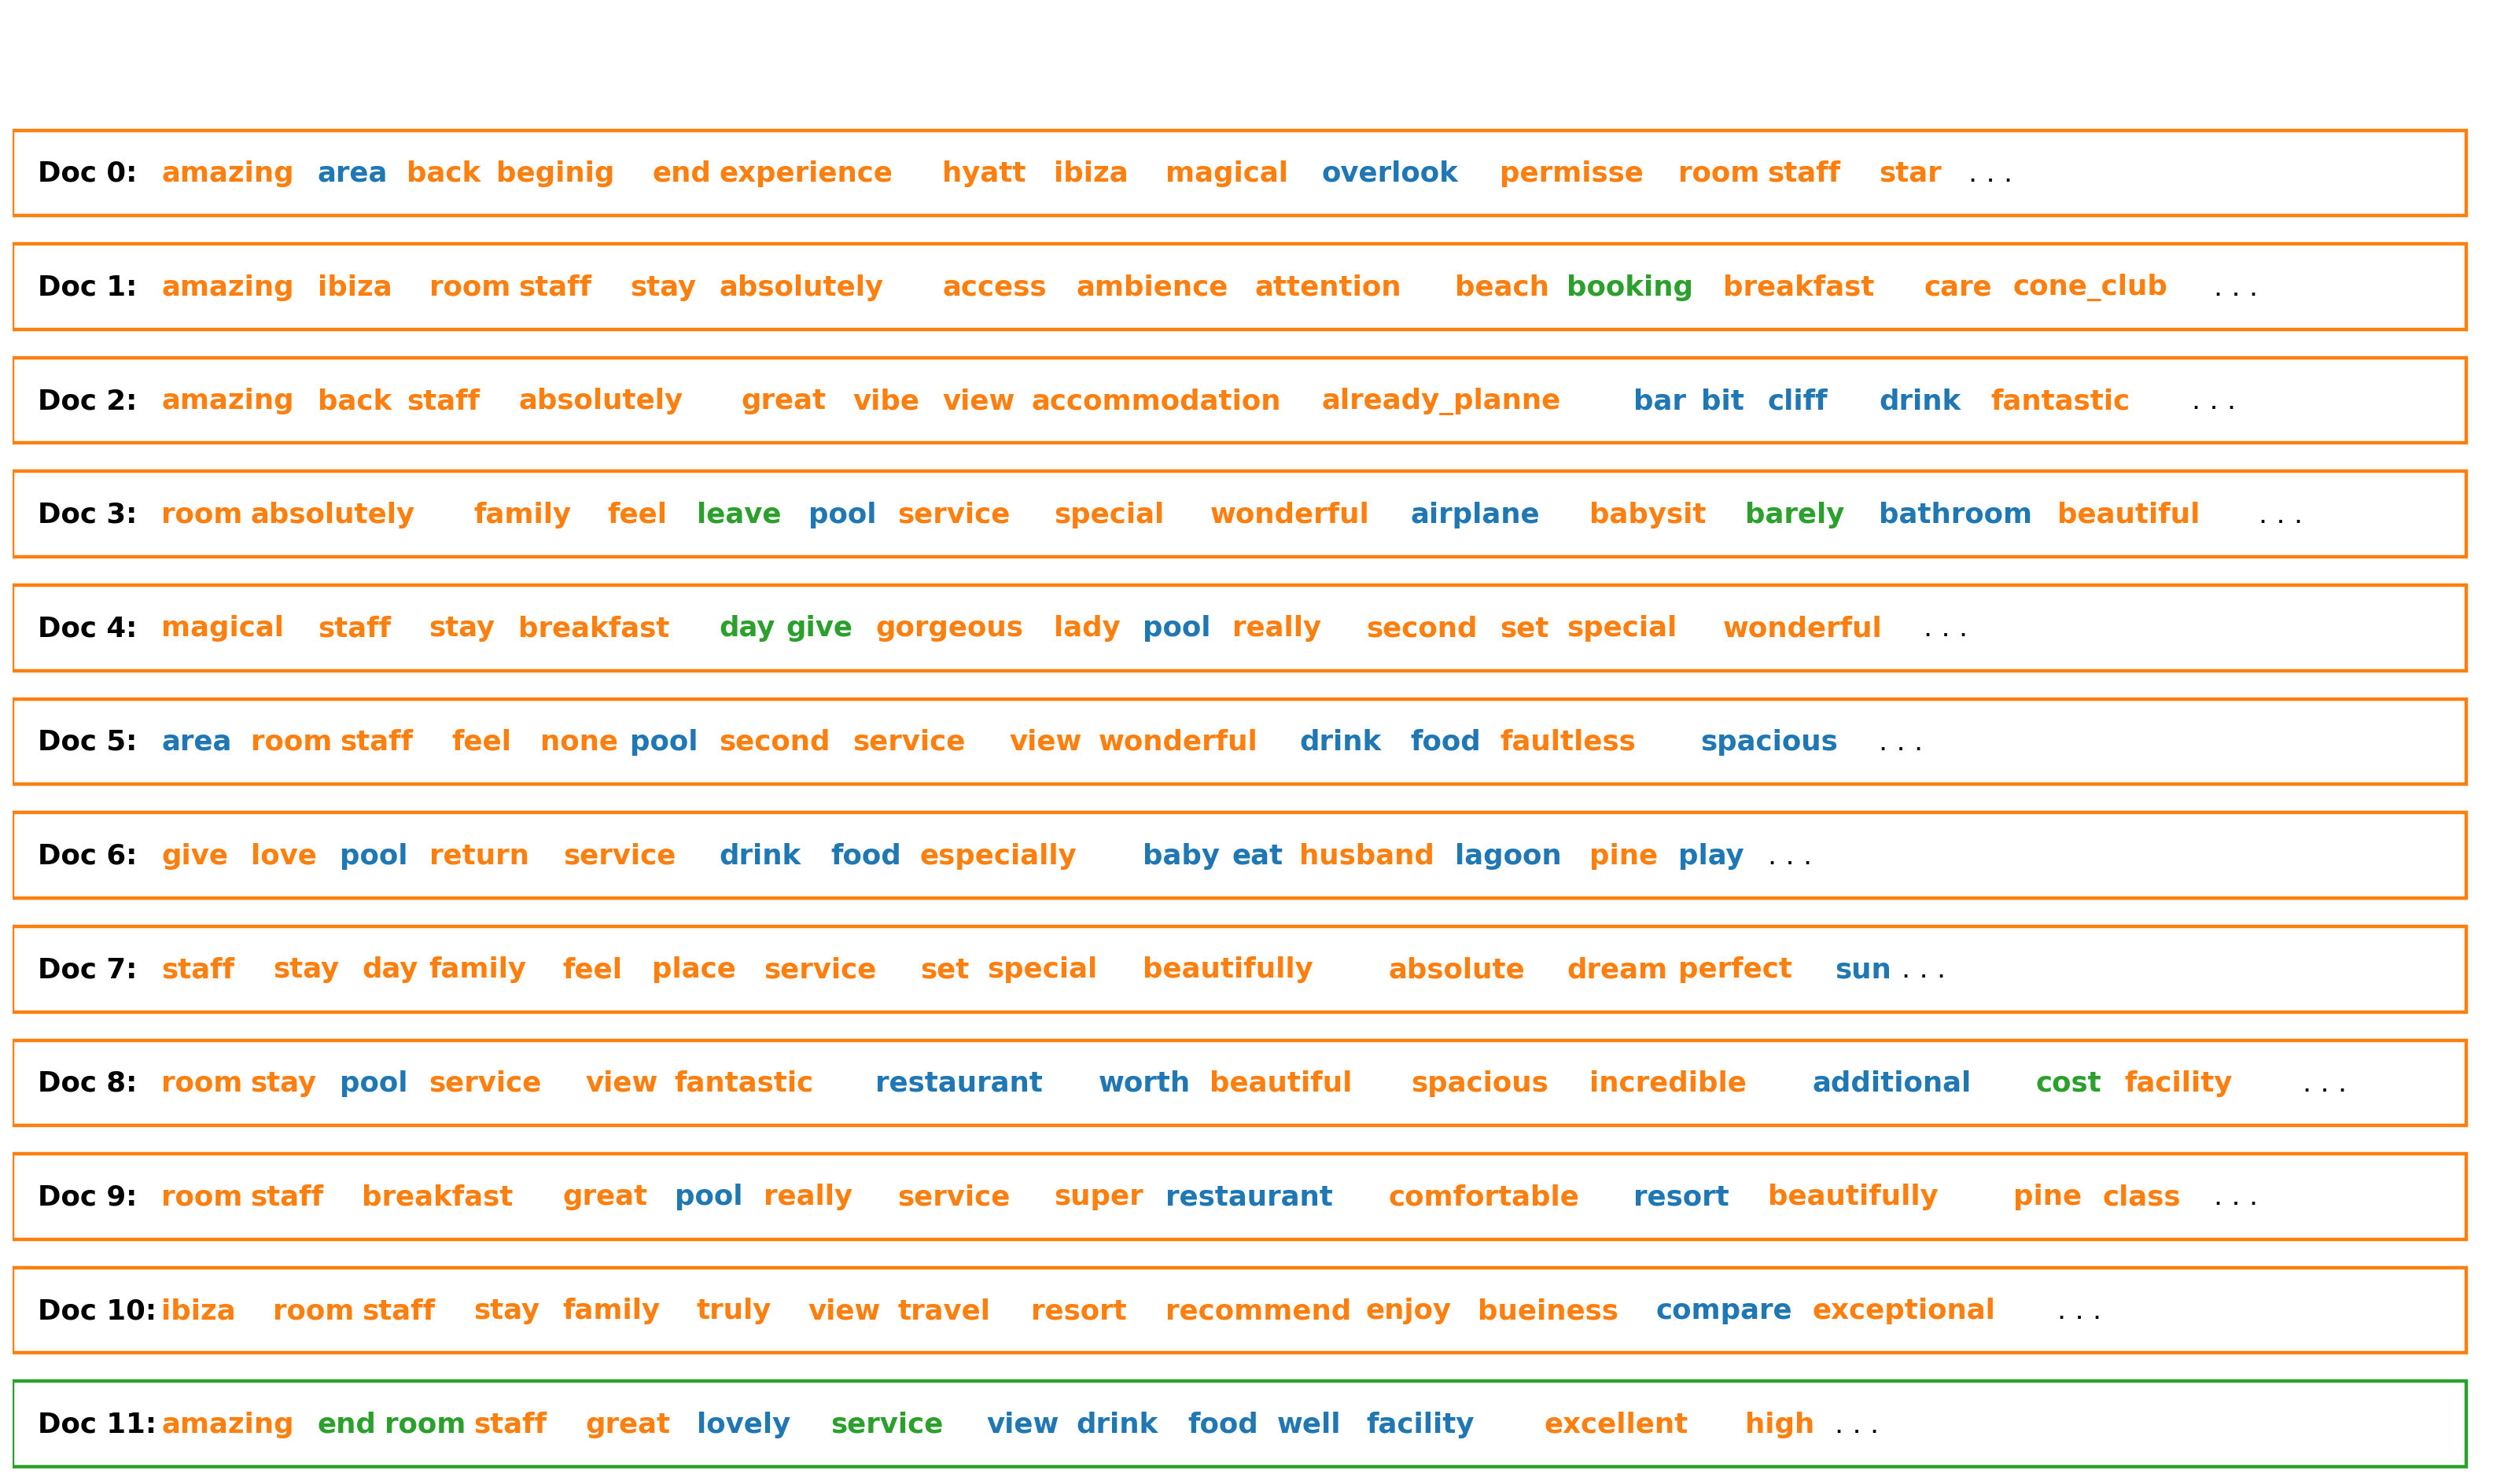

In [54]:
# Sentence Coloring of N Sentences
from matplotlib.patches import Rectangle

def sentences_chart(lda_model=lda_model, corpus=corpus, start = 0, end = 13):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart()

In [65]:
raw_df = pd.read_csv(f'{period_name}.csv')
raw_df.head()

,Unnamed: 0,date,review_text,rating
0,0,2023-05-01,"Five stars hotel from beginig to end. Permisses, Staff, room, comon areas made our stay amazing....",5
1,1,2023-02-01,"Paradise does indeed exist!\nI absolutely LOVED this hotel, for so many reasons. The views are e...",4
2,2,2022-11-01,"Had an absolutely fantastic time at this property. The accommodations were outstanding, the food...",5
3,3,2022-10-01,Hotel is in a beautiful setting and the service was faultless especially the Concierge who were ...,4
4,4,2022-10-01,So worthy of their Conde Nast award - and beyond!! Our third stay and it just gets more and more...,5


In [66]:
df_dominant_topic.head()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1,0.7933,"staff, stay, great, friendly, amazing, service, room, food, recommend, back","[star, beginig, end, permisse, staff, room, area, stay, amazing, overlook, unforgetable, experie..."
1,1,1,0.6936,"staff, stay, great, friendly, amazing, service, room, food, recommend, back","[indeed, exist, absolutely, love, reason, view, exquisite, infinity, pool, world, cone_club, sup..."
2,2,1,0.7715,"staff, stay, great, friendly, amazing, service, room, food, recommend, back","[absolutely, fantastic, time, property, accommodation, outstanding, food, vibe, amazing, staff, ..."
3,3,1,0.4279,"staff, stay, great, friendly, amazing, service, room, food, recommend, back","[beautiful, setting, service, faultless, especially, concierge, garden, suite, pool, generally, ..."
4,4,1,0.6135,"staff, stay, great, friendly, amazing, service, room, food, recommend, back","[worthy, third, stay, wonderful, time, set, stunning, staff, really, special, soul, resort, magi..."


In [76]:
merged_df = raw_df.merge(df_dominant_topic, how='inner', left_on="Unnamed: 0", right_on="Document_No").drop(["Unnamed: 0", "Document_No", "Text"], axis=1)
# merged_df.to_csv(f'{period_name}.csv')
merged_df.sample(10)

,date,review_text,rating,Dominant_Topic,Topic_Perc_Contrib,Keywords
424,2023-04-01,Amazing experience from the moment we stepped in throughout our stay.5* . Will extend my stay wh...,5,1,0.8361,"staff, stay, great, friendly, amazing, service, room, food, recommend, back"
1830,2022-09-01,"A lovely holiday in a lovely hotel,nicely freshened up since takeover from sandos nice to see th...",4,2,0.4172,"room, service, stay, day, time, night, star, staff, ask, guest"
2747,2022-04-01,We stayed at Casa Fuster for a week while in Barcelona. The hotel is beautiful and the staff far...,5,0,0.6467,"pool, room, restaurant, food, bar, area, child, bed, kid, lovely"
2296,2023-01-01,Sewer-smeled hotel with no places to enjoy around the pool. Under staffed service and a hostes t...,1,0,0.6196,"pool, room, restaurant, food, bar, area, child, bed, kid, lovely"
1929,2022-03-01,"With the spacious and clean rooms, balconies overlooking the sea, numerous swimmingpools, excell...",5,0,0.4616,"pool, room, restaurant, food, bar, area, child, bed, kid, lovely"
2844,2022-10-01,"Wonderful low rise hotel. All rooms face inwards towards the pool and garden. No noise, tranquil...",5,1,0.6475,"staff, stay, great, friendly, amazing, service, room, food, recommend, back"
667,2023-03-01,"Please don’t stay here !! The RIU palace is ten of this hotel , it’s a shame for the staff as th...",1,2,0.5461,"room, service, stay, day, time, night, star, staff, ask, guest"
899,2023-03-01,"Amazing hotel.\nAfter reading bad reviews I was worried, but I really didn’t need to be.\n\nThe ...",5,0,0.3672,"pool, room, restaurant, food, bar, area, child, bed, kid, lovely"
790,2022-05-01,First time to Europe for me and traveled to Madrid and Barcelona. Then to Tenerife for a wedding...,5,0,0.5736,"pool, room, restaurant, food, bar, area, child, bed, kid, lovely"
72,2022-06-01,4 night stay with two children was wonderful. stunning setting above the sea. clean new rooms.\n...,5,0,0.4821,"pool, room, restaurant, food, bar, area, child, bed, kid, lovely"


In [ ]:
merged_df.to_csv(f'merged_topics_{period_name}.csv')